# Analysis of Datetime Bugs

In [42]:
# Install dependencies if missing
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install wordcloud

import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

SAVE_PATH = "./visualizations/"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal si

In [43]:
# Cleanup the data and prepare it for visualization

# Read the data from the TSV file
df = pd.read_csv('./data/bug_analysis_base.tsv', sep='\t')

# Filter out rows that are not relevant
df = df[df['Skipped?'] != True]
df = df[df['False pos?'] != True]
df = df[(df['Training?'] == True) | (df['Testing?'] == True) | (df['Set 3?'] == True)]

# Drop columns
df = df.drop(columns=['Link', 'Fix Link', 'Make Benchmark?', 'Associated Benchmark', 'Rater', 'Training?', 'Testing?', 'Skipped?', 'False pos?', 'Set 3?', 'Real Testing?']) 

print("Total number of datapoints: ", len(df))

df.head()

Total number of datapoints:  173


,Owner,Project,Title,Stars,TF-IDFs,Size,Datetime,Arrow,Pendulum,Description,...,Affected Computation 2,Affected Computation 3,Obscurity,Impact/Severity,# LOC,Logic Needed,Comments,BPST1,BPST2,BPST3
0,python-poetry,tomlkit,datetime.utcnow and datetime.utcfromtimestamp ...,643.0,1.312623,1001.0,1.0,0.0,0.0,NaN,...,NaN,NaN,Low,Low,Low,Low,NaN,Outdated/Deprecated APIs,NaN,NaN
1,frictionlessdata,frictionless-py,SpssParser ignores timezones,683.0,1.270077,1279.0,1.0,0.0,0.0,NaN,...,String Parsing/Formatting (data),NaN,Low,Medium,Medium,High,NaN,Dropping Timezones,NaN,NaN
2,sdispater,pendulum,Deepcopy of Month-based Duration produces a di...,6109.0,1.191295,1014.0,1.0,0.0,1.0,NaN,...,NaN,NaN,Medium,Medium,Medium,Low,NaN,Unintuitive Arithmetic,NaN,NaN
3,googleapis,python-storage,`DeprecationWarning` warning in build log for ...,420.0,1.176351,10349.0,1.0,0.0,0.0,NaN,...,NaN,NaN,Low,Low,Low,Low,NaN,Outdated/Deprecated APIs,NaN,NaN
4,googleapis,python-logging,`DeprecationWarning` warning in build log for ...,119.0,1.167279,2673.0,1.0,0.0,0.0,NaN,...,NaN,NaN,Low,Low,Low,Low,NaN,Outdated/Deprecated APIs,NaN,NaN


df.columns
"""
Index(
       ['Owner', 'Project', 'Title', 'Stars', 'TF-IDFs', 'Size', 'Datetime',
       'Arrow', 'Pendulum', 'Description', 'Category 1', 'Category 2',
       'Affected Computation 1', 'Affected Computation 2',
       'Affected Computation 3', 'Obscurity', 'Impact/Severity', '# LOC',
       'Logic Needed', 'Comments', 'BPST1', 'BPST2', 'BPST3'],
dtype='object')
"""

## What are the highlevel terms used to describe date and time bugs?

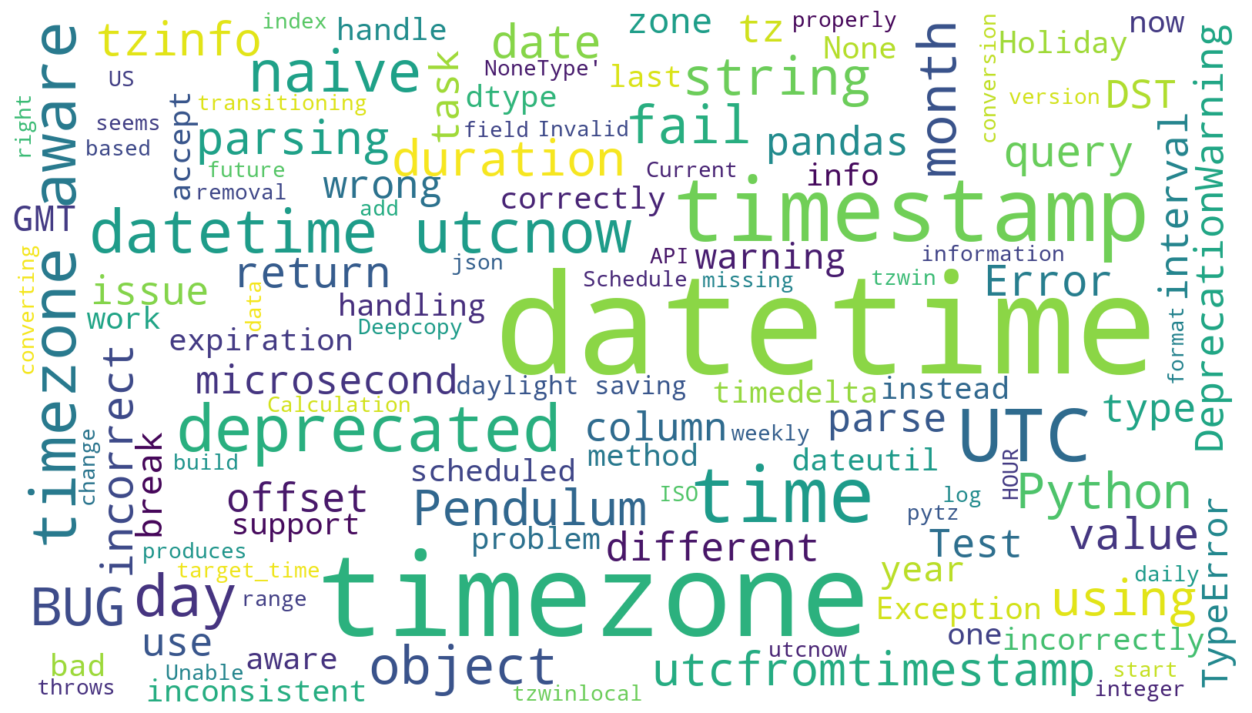

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 1. Combine all text from the column into a single string
text = ' '.join(df['Title'].astype(str))

# 2. Create a WordCloud object
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    max_font_size=180,
    max_words=120,
    background_color="white",
    colormap='viridis',
    # mask=datetime_mask,
    contour_width=1,
    ).generate(text)

# 3. Display the generated image
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(SAVE_PATH+'wordcloud.png')
plt.show()


# What can be done to improve datetime logic in opensource software?
1. To what extent are the fixes localized?
2. How logically involved were these fixes?
3. How hard were these bugs to detect?

# LOC
Medium       71
Low          55
High         15
Very High    12
Name: count, dtype: int64


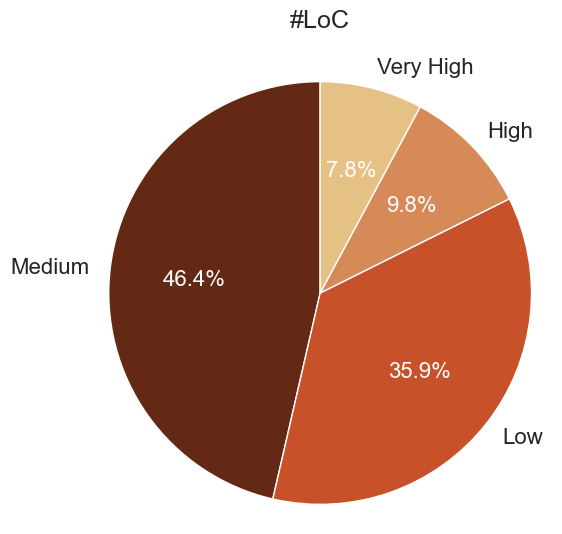

Logic Needed
Low       85
Medium    53
High      15
Name: count, dtype: int64


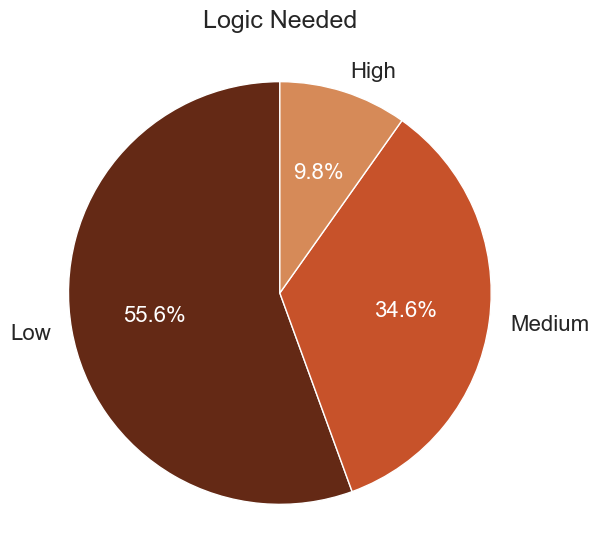

Obscurity
Low       91
Medium    50
High      12
Name: count, dtype: int64


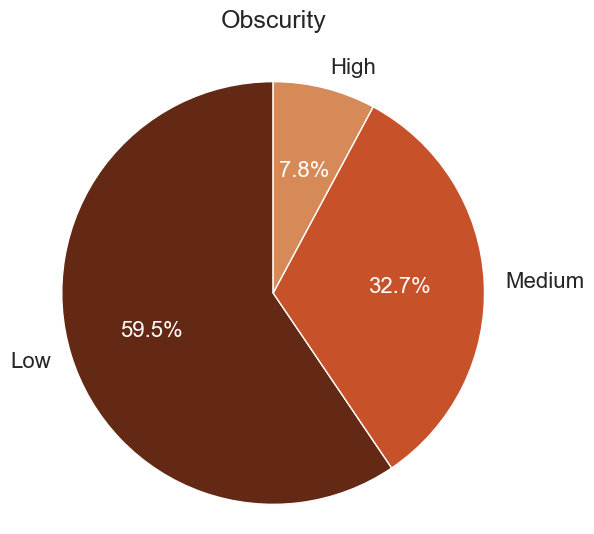

In [33]:
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Q1
category_counts = df['# LOC'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('#LoC\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH+'bugs_localized.png', transparent=True)
plt.show()


# Q2
category_counts = df['Logic Needed'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Logic Needed\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH+'bugs_logic_needed.png', transparent=True)
plt.show()


# Q3
category_counts = df['Obscurity'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Obscurity\n', fontsize=18)  # Adjust the title size here
plt.axis('equal')
plt.savefig(SAVE_PATH + 'bugs_obscurity.png', transparent=True)
plt.show()

## What are the most common causes of bugs?
### Plot the Broad Categories.

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_1314/2607292142.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


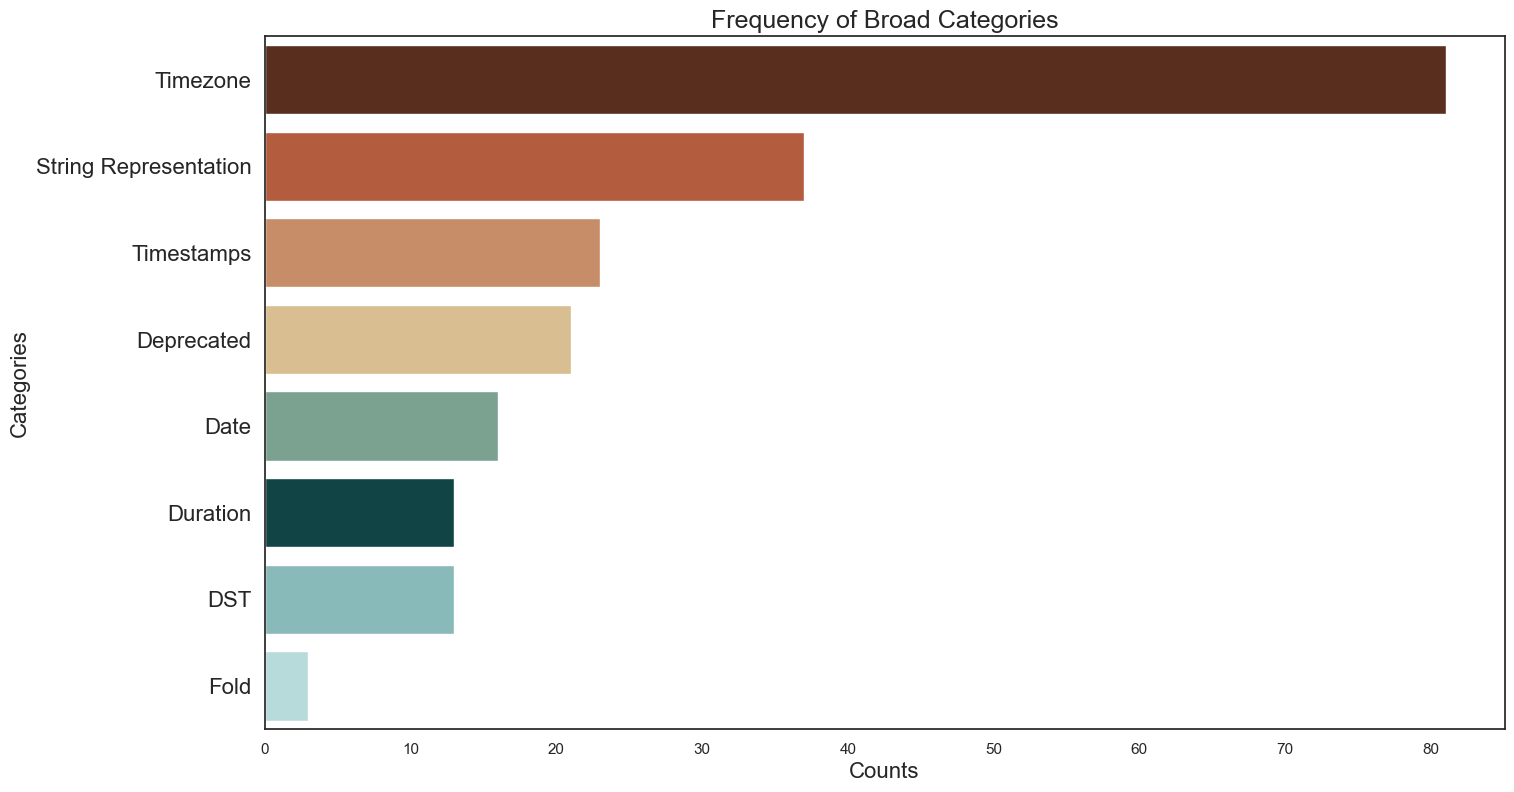

In [44]:
# Bar chart of Broad Categories

# Merge both categories into one Series
combined_categories = pd.concat([df['Category 1'], df['Category 2']])

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Set the theme for seaborn
sns.set_theme(style='white')

# Plotting
plt.figure(figsize=(16, 9))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
ax.set_title('Frequency of Broad Categories', fontsize=18)
ax.set_xlabel('Counts', fontsize=16)
ax.set_ylabel('Categories', fontsize=16)
ax.tick_params(axis='y', labelsize=16)  # Use this to control y-tick label sizes

plt.savefig(SAVE_PATH + 'broad_categories.png', transparent=True)
plt.show()

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_1314/1945986569.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_1314/1945986569.py:26: UserWarning: 
The palette list has fewer values (8) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


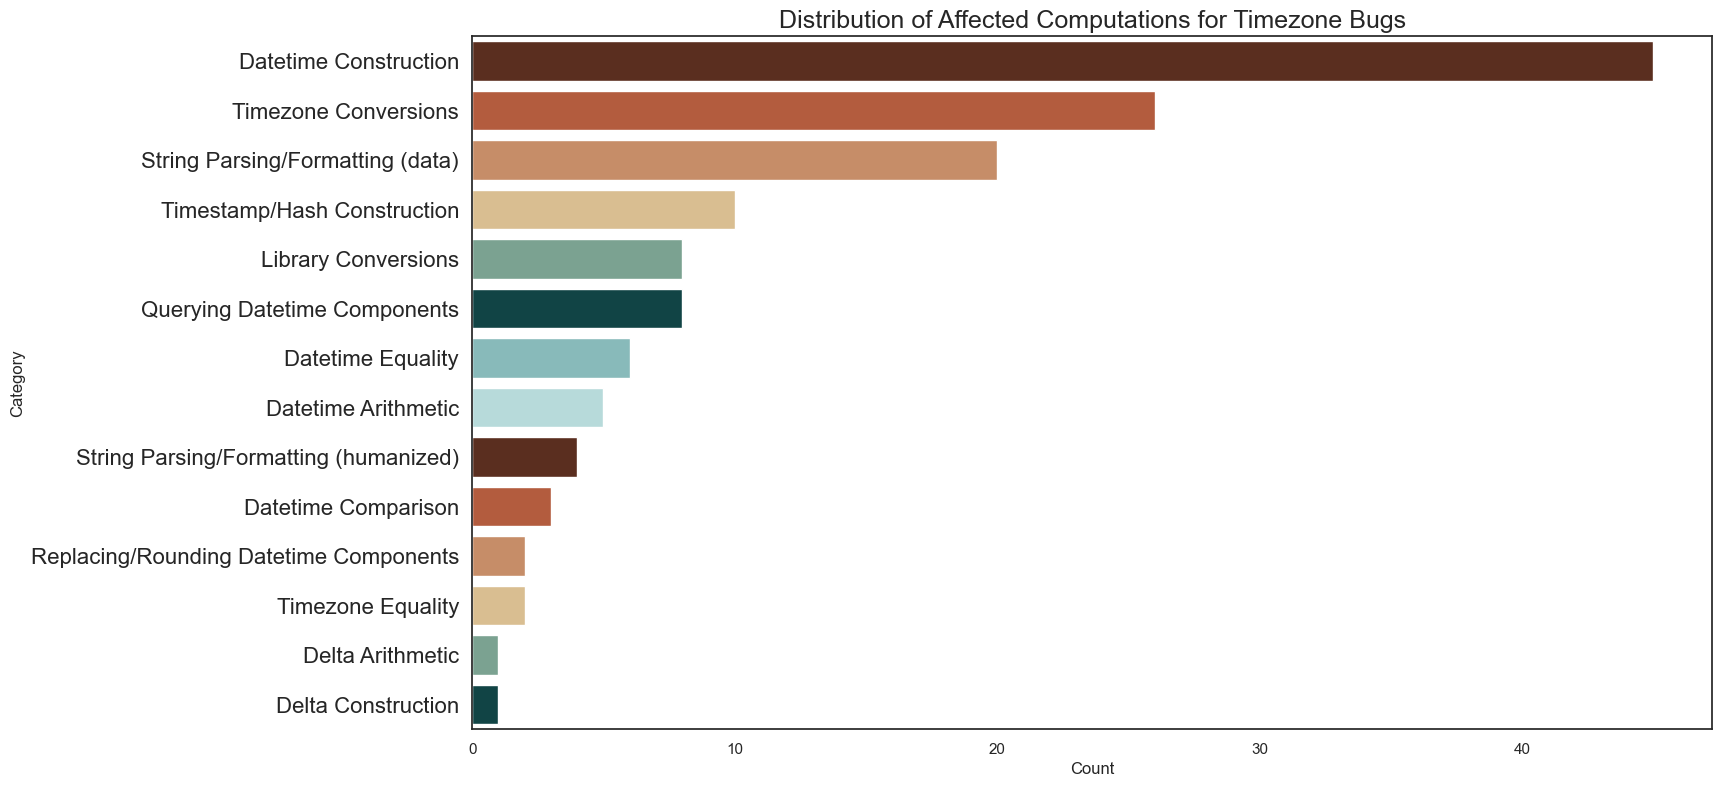

In [46]:
# What are the most common affected computations for the Timezone category?

# Filter the DataFrame to only include the Timezone category
timezone_df = df[(df['Category 1'] == 'Timezone') | (df['Category 2'] == 'Timezone')]
timezone_df = timezone_df.drop(columns=['Category 1', 'Category 2'])

# Merge both categories into one Series
combined_categories = pd.concat([timezone_df['Affected Computation 1'], timezone_df['Affected Computation 2'], timezone_df['Affected Computation 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Set the theme for seaborn
sns.set_theme(style='white')

# Plotting
plt.figure(figsize=(16, 9))
ax = sns.barplot(y='Count', x='Category', data=category_counts, palette=colors)
ax.set_title('Distribution of Affected Computations for Timezone Bugs', fontsize=18)
# ax.set_xlabel('Counts', fontsize=16)
# ax.set_ylabel('Affected Computations', fontsize=16)
ax.tick_params(axis='y', labelsize=16)  # Use this to control y-tick label sizes

plt.savefig(SAVE_PATH + 'timezone_affected_computations.png', transparent=True)
plt.show()


Color map: ['#642915', '#c7522a', '#d68a58', '#e5c185', '#74a892', '#094d4d', '#80c2c2', '#b1e0e0']


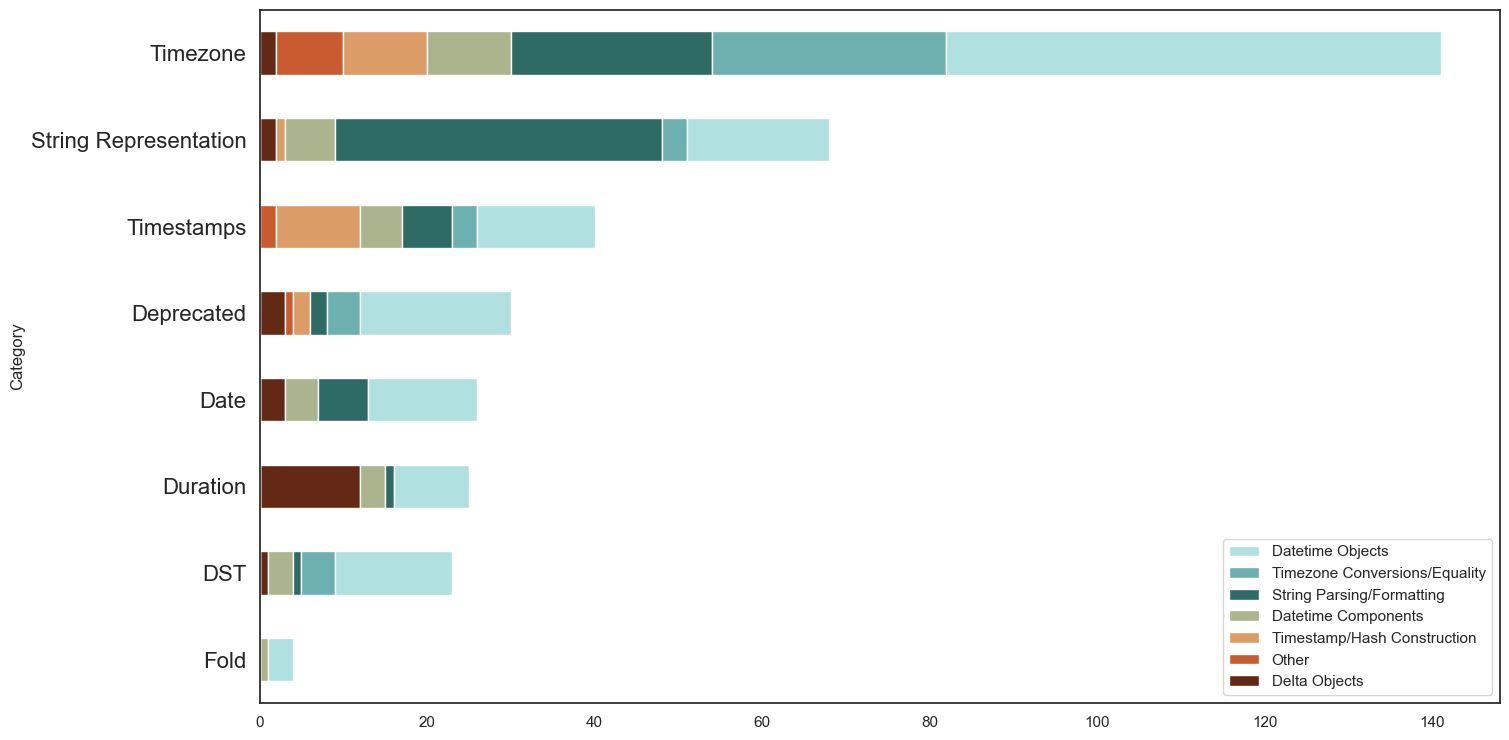

In [30]:
# Stacked Bar Chart of Broad Categories and (Bucketed) Affected Computations.

categories = [
  "Date",
  "DST",
  "Duration",
  "String Representation",
  "Timestamps",
  "Timezone",
  "Deprecated",
  "Fold",
]

"""
All Affected Computations Types:

Timestamp/Hash Construction
Datetime Arithmetic
Datetime Comparison
Datetime Construction
Datetime Equality
Delta Arithmetic
Delta Comparison
Delta Construction
Delta Conversion
Delta Equality
Querying Datetime Components
Replacing/Rounding Datetime Components
String Parsing/Formatting (humanized)
String Parsing/Formatting (data)
Timezone Conversions
Timezone Equality
Library Conversion
"""

affected_comp = [
  "Timestamp/Hash Construction",
  "Datetime Objects",
  "Delta Objects",
  "Datetime Components",
  "String Parsing/Formatting",
  "Timezone Conversions/Equality",
  "Other",
]

acmap = {"Category": categories, "total": [0]*len(categories)}
for ac in affected_comp:
    acmap[ac] = [0]*len(categories)
    
for index,row in df.iterrows():
    indecies = []
    for c in [row['Category 1'], row['Category 2']]:
      if type(c) is str:
        index = categories.index(c)
        acmap["total"][index] += 1
        indecies.append(index)
    for ac in [row['Affected Computation 1'], row['Affected Computation 2'], row['Affected Computation 3']]:
        if type(ac) is str:
            if ac=="Datetime Arithmetic" or ac=="Datetime Comparison" or ac=="Datetime Construction" or ac=="Datetime Equality":
              ac = "Datetime Objects"
            elif ac=="Delta Arithmetic" or ac=="Delta Comparison" or ac=="Delta Construction" or ac=="Delta Equality" or ac=="Delta Conversion":
              ac = "Delta Objects"
            elif ac=="Querying Datetime Components" or ac=="Replacing/Rounding Datetime Components":
              ac = "Datetime Components"
            elif ac=="String Parsing/Formatting (humanized)" or ac=="String Parsing/Formatting (data)":
              ac = "String Parsing/Formatting"
            elif ac=="Timezone Conversions" or ac=="Timezone Equality":
              ac = "Timezone Conversions/Equality"
            elif ac=="Timestamp/Hash Construction":
              ac = "Timestamp/Hash Construction"    
            else:
              ac = "Other"
      
            for i in indecies:
                acmap[ac][i] += 1

sns.set_theme(style='white')
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
print("Color map:", colors)


temp_df = pd.DataFrame(acmap).set_index('Category')

temp_df = temp_df.sort_values("total").sort_values("Timezone", axis=1).drop(columns="total")
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
ax = temp_df.plot( kind='barh', legend='reverse', colormap=custom_cmap, stacked=True, figsize=(16, 9))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.savefig(SAVE_PATH+'broad_categories_stacked.png', transparent=True)

Total number of DST bugs:  13
Impact/Severity
Medium    9
Low       3
High      1
Name: count, dtype: int64


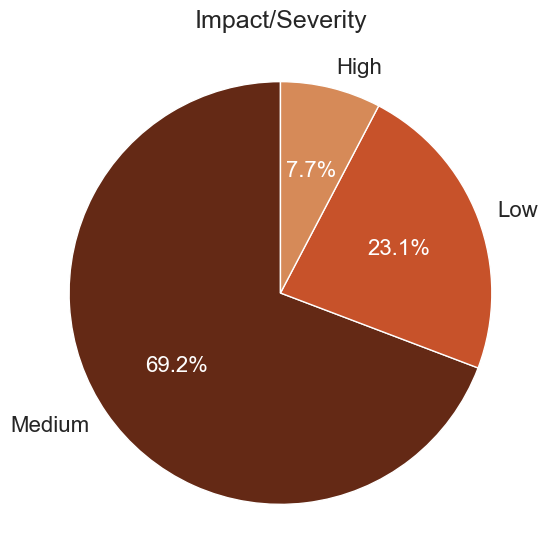

In [32]:
#About DST Bugs.

temp_df = df[((df['Category 1'] == "DST") | (df['Category 2'] == "DST"))]

#print the length of the dataframe
print("Total number of DST bugs: ", len(temp_df))

category_counts = temp_df['Impact/Severity'].value_counts()
print(category_counts)

plt.figure(figsize=(6, 6))
wedges, labels, autopct_texts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 16}  # Adjust the label size here
)

for text in autopct_texts:
    text.set_color('white')
    text.set_fontsize(16)  # Adjust the percentage size here

plt.title('Impact/Severity\n', fontsize=18)
plt.axis('equal')
plt.savefig(SAVE_PATH+'dst_impact_severity.png', transparent=True)
plt.show()

                                  Tag  Counts
0    Using Naïve Datetime Incorrectly      39
1            Outdated/Deprecated APIs      22
2                  Dropping Timezones      21
3              Unintuitive Arithmetic      17
4         Precision of Representation      17
5        Incorrect Format Assumptions      15
6                         Library Bug       8
7                Compatibility Issues       6
8                 Incorrect API usage       5
9   Creating time in unspecified fold       4
10                     OOB Timestamps       4
11                      OOB Datetimes       4


/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_1314/134137970.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Counts', y='Tag', data=tag_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_1314/134137970.py:41: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='Counts', y='Tag', data=tag_counts, palette=colors)


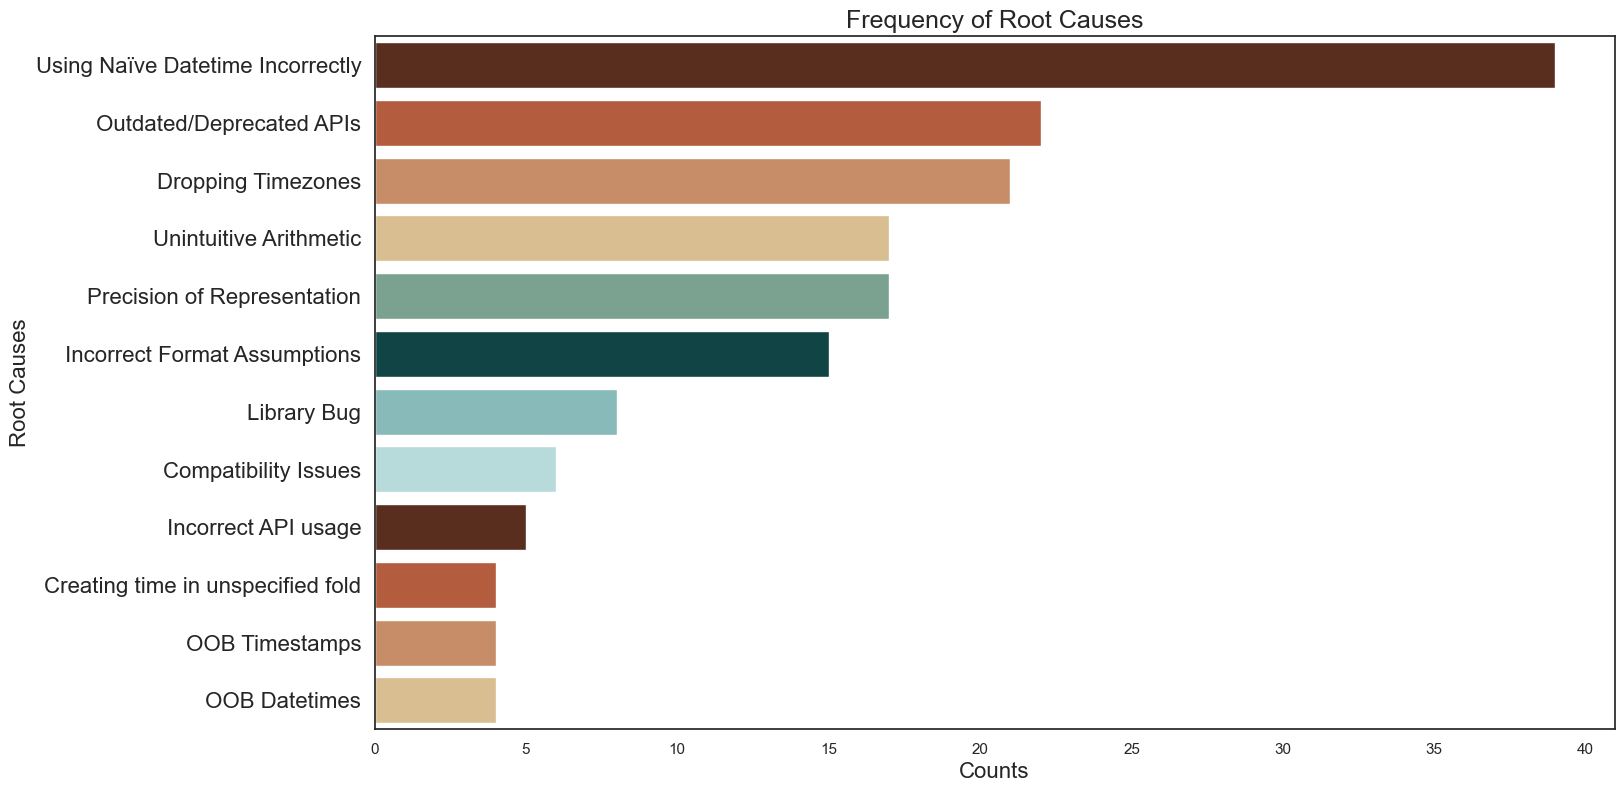

In [39]:
# What are the root causes of bugs?

# Define the categories as a list
categories = [
    "Incorrect API usage", 
    "Outdated/Deprecated APIs", 
    "Using Naïve Datetime Incorrectly", 
    "Dropping Timezones", 
    "Precision of Representation", 
    "Library Bug", 
    "OOB Timestamps", 
    "OOB Datetimes", 
    "Creating time in unspecified fold", 
    "Unintuitive Arithmetic", 
    "Compatibility Issues", 
    "Incorrect Format Assumptions"
]

# Melt the DataFrame to consolidate all tags into a single column
melted_df = df.melt(value_vars=['BPST1', 'BPST2', 'BPST3'], value_name='Tag')

# Filter the melted DataFrame to keep only valid tags
melted_df = melted_df[melted_df['Tag'].isin(categories)]

# Count occurrences of each tag
tag_counts = melted_df['Tag'].value_counts().reset_index()
tag_counts.columns = ['Tag', 'Counts']
tag_counts = tag_counts.sort_values(by='Counts', ascending=False)

# Print the counts
print(tag_counts)

# Define the colors
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]

# Set the theme for seaborn
sns.set_theme(style='white')

# Plotting the bar chart
plt.figure(figsize=(16, 9))
ax = sns.barplot(x='Counts', y='Tag', data=tag_counts, palette=colors)

# Add title and labels
ax.set_title('Frequency of Root Causes', fontsize=18)
ax.set_xlabel('Counts', fontsize=16)
ax.set_ylabel('Root Causes', fontsize=16)
ax.tick_params(axis='y', labelsize=16)

# Save and show the plot
plt.savefig(SAVE_PATH + 'root_causes.png', transparent=True)
plt.show()

### What are the characteristics of each category?
##### Measure of obscurity and impact/severity for each category

{'Datetime Construction': {'Low Obscurity': 27, 'Medium Obscurity': 16, 'High Obscurity': 2, 'Low Impact/Severity': 5, 'Medium Impact/Severity': 35, 'High Impact/Severity': 5}, 'Library Conversions': {'Low Obscurity': 5, 'Medium Obscurity': 3, 'High Obscurity': 0, 'Low Impact/Severity': 1, 'Medium Impact/Severity': 6, 'High Impact/Severity': 1}, 'String Parsing/Formatting (data)': {'Low Obscurity': 11, 'Medium Obscurity': 9, 'High Obscurity': 0, 'Low Impact/Severity': 2, 'Medium Impact/Severity': 16, 'High Impact/Severity': 2}, 'Timezone Conversions': {'Low Obscurity': 18, 'Medium Obscurity': 6, 'High Obscurity': 2, 'Low Impact/Severity': 3, 'Medium Impact/Severity': 18, 'High Impact/Severity': 5}, 'Timestamp/Hash Construction': {'Low Obscurity': 8, 'Medium Obscurity': 2, 'High Obscurity': 0, 'Low Impact/Severity': 0, 'Medium Impact/Severity': 10, 'High Impact/Severity': 0}, 'Datetime Arithmetic': {'Low Obscurity': 2, 'Medium Obscurity': 2, 'High Obscurity': 1, 'Low Impact/Severity': 2

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_48727/1462661391.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(percentages, ha='right')


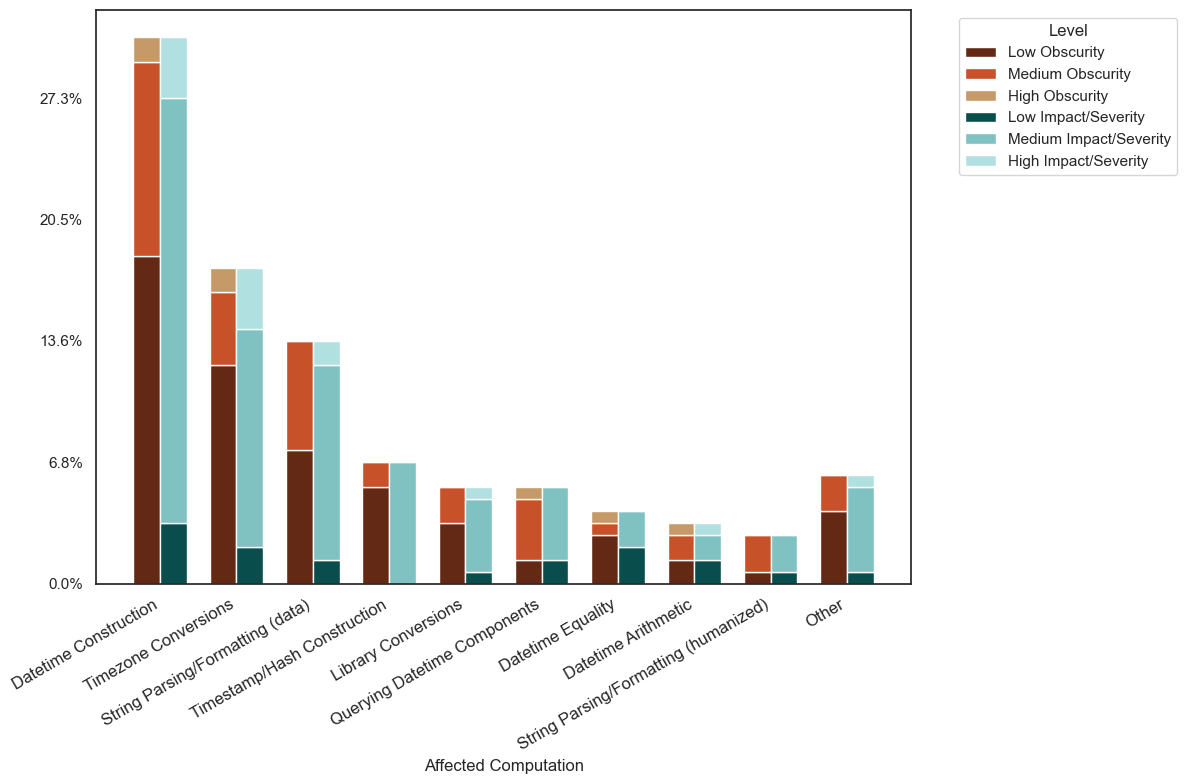

In [135]:
results = {}

# df = df[(df['Category 1'] == "Timezone") | (df['Category 2'] == "Timezone")]

# Combine unique categories from both columns
categories = pd.concat([df['Affected Computation 1'], df['Affected Computation 2'], df['Affected Computation 3']], axis=0).unique()

# Loop through each unique category
for category in categories:
    # Filter the DataFrame for the current category
    df_category = df[(df['Affected Computation 1'] == category) | (df['Affected Computation 2'] == category) | (df['Affected Computation 3'] == category)]

    # Count the occurrences of each obscurity level
    counts_o = df_category['Obscurity'].value_counts().to_dict()
    counts_s = df_category['Impact/Severity'].value_counts().to_dict()

    # Ensure all levels are included in the result
    results[category] = {
        'Low Obscurity': counts_o.get('Low', 0),
        'Medium Obscurity': counts_o.get('Medium', 0),
        'High Obscurity': counts_o.get('High', 0),
        'Low Impact/Severity': counts_s.get('Low', 0),
        'Medium Impact/Severity': counts_s.get('Medium', 0),
        'High Impact/Severity': counts_s.get('High', 0)
    }

print(results)

# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Calculate the size of each category
results_df['Total'] = results_df.sum(axis=1)

# Select the top 5 categories by size
top_categories = results_df.nlargest(9, 'Total')

# Select the remaining categories for "Other"
other_categories = results_df.drop(top_categories.index)

# Sum the counts for the "Other" category
other_sums = other_categories.sum()
other_sums.name = 'Other'

# Append the "Other" category to the top categories
top_categories = pd.concat([top_categories, other_sums.to_frame().T])


# Create a grouped bar chart for the top 5 categories + "Other"
categories = top_categories.index
percentages = [f"{float(int(342 * i / 5))/10}%" for i in range(100)]
obscurity_counts = top_categories[['Low Obscurity', 'Medium Obscurity', 'High Obscurity']]
severity_counts = top_categories[['Low Impact/Severity', 'Medium Impact/Severity', 'High Impact/Severity']]

x = pd.Index(range(len(categories)))  # the label locations
width = 0.35  # the width of the bars

# colors = ['#FBFBF2', '#E5E6E4', '#CFD2CD', '#A6A2A2', '#847577', '#615758']
#colors = ['#10A0EC', '#7CC6FE', '#ACD5FF', '#E7BBE3', '#C884A6', '#B25282']
colors = ["#642915", "#c7522a", "#c69a68", "#094d4d", "#80c2c2", "#b1e0e0"]

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, obscurity_counts['Low Obscurity'], width, label='Low Obscurity', color=colors[0])
rects2 = ax.bar(x - width/2, obscurity_counts['Medium Obscurity'], width, bottom=obscurity_counts['Low Obscurity'], label='Medium Obscurity', color=colors[1])
rects3 = ax.bar(x - width/2, obscurity_counts['High Obscurity'], width, bottom=obscurity_counts['Low Obscurity'] + obscurity_counts['Medium Obscurity'], label='High Obscurity', color=colors[2])

rects4 = ax.bar(x + width/2, severity_counts['Low Impact/Severity'], width, label='Low Impact/Severity', color=colors[3])
rects5 = ax.bar(x + width/2, severity_counts['Medium Impact/Severity'], width, bottom=severity_counts['Low Impact/Severity'], label='Medium Impact/Severity', color=colors[4])
rects6 = ax.bar(x + width/2, severity_counts['High Impact/Severity'], width, bottom=severity_counts['Low Impact/Severity'] + severity_counts['Medium Impact/Severity'], label='High Impact/Severity', color=colors[5])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Affected Computation')
ax.set_ylabel('')
#ax.set_title('Categories vs Impact/Severity and Obscurity')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=12)
ax.set_yticklabels(percentages, ha='right')
ax.legend(title='Level', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()

plt.show()

fig.savefig(SAVE_PATH+'timezone_affected_computations.png', transparent=True)

### What are the BPSTs associated with each category?
##### Proportion of BPSTs for each category

Color map: ['#642915', '#c7522a', '#d68a58', '#e5c185', '#74a892', '#094d4d', '#80c2c2', '#b1e0e0']


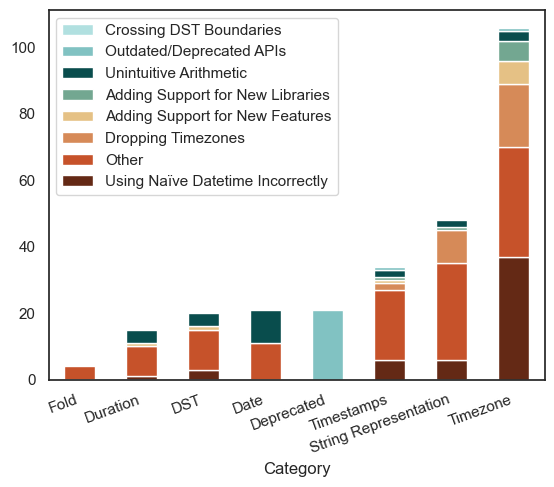

In [38]:
categories = """Date
DST
Duration
String Representation
Timestamps
Timezone
Fold
Deprecated""".split("\n")

bpsts_short = """Outdated/Deprecated APIs
Using Naïve Datetime Incorrectly
Dropping Timezones
Adding Support for New Features
Unintuitive Arithmetic
Adding Support for New Features
Adding Support for New Libraries
Crossing DST Boundaries
Other""".split("\n")
# only categories listed >=8 times

bpsts = """Incorrect API usage
Outdated/Deprecated APIs
Calling datetime.now() Multiple Times
Using Naïve Datetime Incorrectly
Dropping Timezones
Typo
Subtracting Dates
Adding Support for New Libraries
Adding Support for New Features
Precision of Representation
Library Bug
OOB Timestamps
OOB Datetimes
Creating time in unspecified fold
Crossing DST boundaries
Comparing Timezones
Unintuitive Arithmetic
TODO
Other""".split("\n")

# Figure 2a - Chart bug patterns across each category

bpstmap = {"Category": categories, "total": [0]*len(categories)}
for bpst in bpsts_short:
    bpstmap[bpst] = [0]*len(categories)

for index,row in df.iterrows():
    cats = [row['Category 1'], row['Category 2']]
    indecies = []
    for c in cats:
        if type(c) is str:
            indecies.append(categories.index(c))
    rowbpsts = [row['BPST1'], row['BPST2'], row['BPST3']]
    for bpst in rowbpsts:
        if type(bpst) is str:
            if bpst not in bpsts_short:
                bpst = "Other"
            for i in indecies:
                bpstmap[bpst][i] += 1
                bpstmap["total"][i] += 1

sns.set(style='white')

# colors = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b','tab20c']
# colors = "Set2"
# colors = "Dark2"
#colors = "tab20b"
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
print("Color map:", colors)

temp_df = pd.DataFrame(bpstmap).set_index('Category')
temp_df = temp_df.sort_values("total").sort_values("Timezone", ascending=False, axis=1).drop(columns="total")
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
ax = temp_df.plot(kind='bar', legend='reverse', colormap=custom_cmap, stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20,ha='right')

plt.savefig(SAVE_PATH+'fig2.png', transparent=True)

### What are the average impact/severity for each BPST?
##### Number of issues with each BPST, and the proportions of them that have low medium or high impact/severity

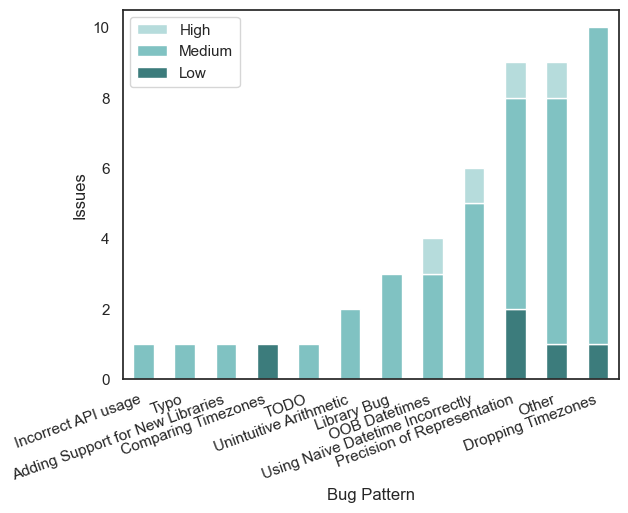

<Figure size 640x480 with 0 Axes>

In [39]:
# Figure 2b - Chart severity across bpst for string rep

df_sr = df[(df['Category 1'] == 'String Representation') | (df['Category 2'] == 'String Representation')]


ratings = ["Low", "Medium", "High"]
temp_data = {"Bug Pattern": bpsts, "total": [0]*len(bpsts)}
for r in ratings:
    temp_data[r] = [0]*len(bpsts)

for index, row in df_sr.iterrows():
    rowbpsts = [row['BPST1'], row['BPST2'], row['BPST3']]
    for bpst in rowbpsts:
        if type(bpst) is str:
            bpst = bpst if bpst in bpsts else "Other"
            val = row["Impact/Severity"]
            temp_data[val][bpsts.index(bpst)] += 1
            temp_data["total"][bpsts.index(bpst)] += 1


temp_df = pd.DataFrame(temp_data).set_index('Bug Pattern')
temp_df = temp_df.loc[temp_df['total'] !=0]
temp_df = temp_df.sort_values("total").drop(columns="total")
#temp_df = temp_df.drop("TODO")

#colors = ['#0a00b3', '#346bcc', '#00a9ec']
# colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[1:4])
colors = ["#3C7C7C", "#80c2c2", "#B6DCDC"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

ax = temp_df.plot(kind='bar', legend='reverse', colormap=custom_cmap, stacked=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20,ha='right')
ax.set_ylabel("Issues")

# rects = ax.patches
# print(rects)

# Make some labels.
# labels = [f"label{i}" for i in range(len(rects))]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
#     )

plt.show()

plt.savefig(SAVE_PATH+'fig2-1.png', transparent=True)

### What is the distribution of logic and impact/severity levels for datetime construction (affected computation) issues?

##### Logic levels and impact/severity levels for datetime construction issues in affected computations

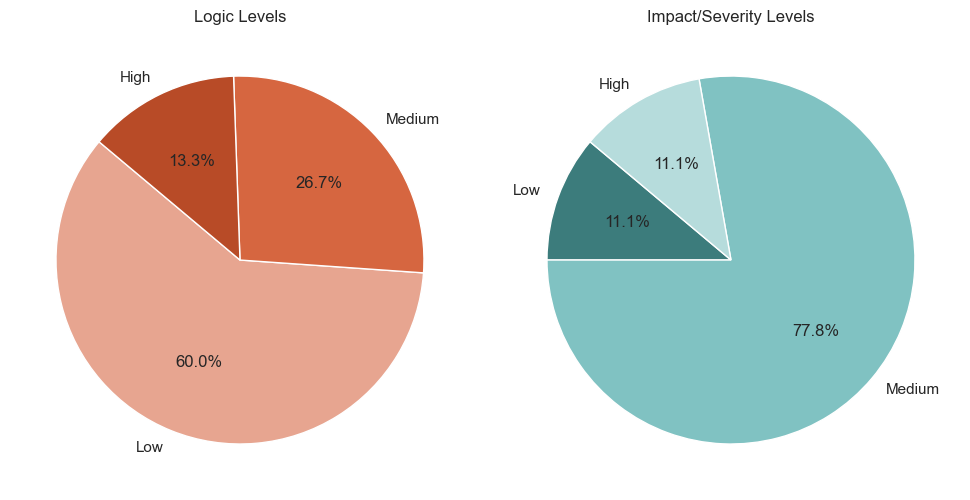

In [81]:
#Datetime Construction
df = df.reset_index(drop=True)

df_TZ = df[(df['Category 1'] == "Timezone") | (df['Category 2'] == "Timezone")]

# print(df_TZ['Affected Computation 1'])

df_TZ_cn = df_TZ[(df_TZ['Affected Computation 1'] == "Datetime Construction") | (df_TZ['Affected Computation 2'] == "Datetime Construction") | (df_TZ['Affected Computation 3'] == "Datetime Construction")]
# df_TZ_cn

logic_data = {}
impact_data = {}

logic_data['Low'] = df_TZ_cn['Logic Needed'].value_counts().get('Low', 0)
logic_data['Medium'] = df_TZ_cn['Logic Needed'].value_counts().get('Medium', 0)
logic_data['High'] = df_TZ_cn['Logic Needed'].value_counts().get('High', 0)


impact_data['Low'] = df_TZ_cn['Impact/Severity'].value_counts().get('Low', 0)
impact_data['Medium'] = df_TZ_cn['Impact/Severity'].value_counts().get('Medium', 0)
impact_data['High'] = df_TZ_cn['Impact/Severity'].value_counts().get('High', 0)

#colors = ['#10A0EC', '#7CC6FE', '#ACD5FF', '#E7BBE3', '#C884A6', '#B25282']
colors = ["#E7A590", "#D66640", "#B84B27", "#3C7C7C", "#80c2c2", "#B6DCDC"]

# Create pie chart for logic levels
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(logic_data.values(), labels=logic_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[0:3])
plt.title('Logic Levels')

# Create pie chart for impact/severity levels
plt.subplot(1, 2, 2)
plt.pie(impact_data.values(), labels=impact_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[3:6])
plt.title('Impact/Severity Levels')

plt.tight_layout()
plt.savefig(SAVE_PATH+'fig1-1_datetime.png', transparent=True)
plt.show()



### What is the distribution of logic and impact/severity levels for issues in the category String Representation?

##### Logic levels and impact/severity levels for String Representation category issues

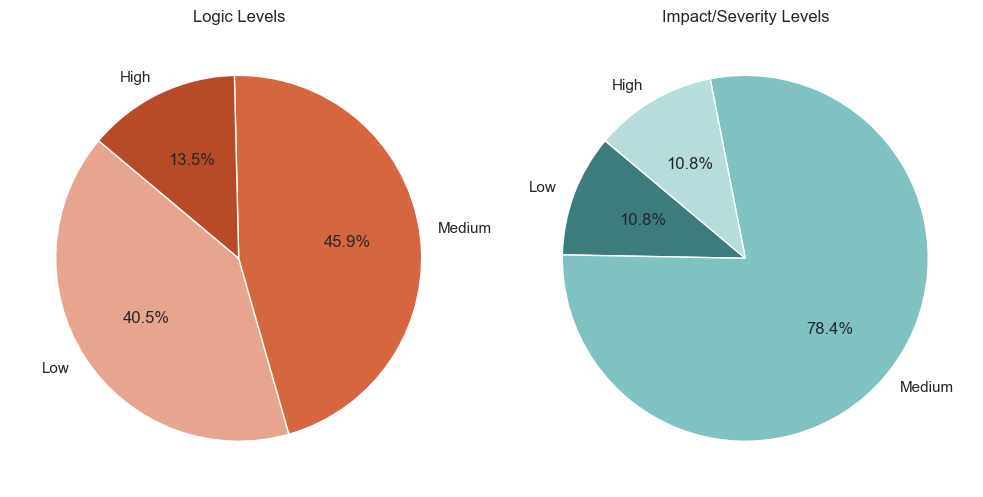

In [80]:
#String Representation
# df = df.reset_index(drop=True)

df_SR = df[(df['Category 1'] == "String Representation") | (df['Category 2'] == "String Representation")]

logic_data = {}
impact_data = {}

logic_data['Low'] = df_SR['Logic Needed'].value_counts().get('Low', 0)
logic_data['Medium'] = df_SR['Logic Needed'].value_counts().get('Medium', 0)
logic_data['High'] = df_SR['Logic Needed'].value_counts().get('High', 0)


impact_data['Low'] = df_SR['Impact/Severity'].value_counts().get('Low', 0)
impact_data['Medium'] = df_SR['Impact/Severity'].value_counts().get('Medium', 0)
impact_data['High'] = df_SR['Impact/Severity'].value_counts().get('High', 0)

#colors = ['#10A0EC', '#7CC6FE', '#ACD5FF', '#E7BBE3', '#C884A6', '#B25282']
colors = ["#E7A590", "#D66640", "#B84B27", "#3C7C7C", "#80c2c2", "#B6DCDC"]

# Create pie chart for logic levels
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(logic_data.values(), labels=logic_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[0:3])
plt.title('Logic Levels')

# Create pie chart for impact/severity levels
plt.subplot(1, 2, 2)
plt.pie(impact_data.values(), labels=impact_data.keys(), autopct='%1.1f%%', startangle=140, colors=colors[3:6])
plt.title('Impact/Severity Levels')

plt.tight_layout()
plt.savefig(SAVE_PATH+'fig1-3_stringrep.png', transparent=True)
plt.show()


### How is each characteristic correlated?
##### Correlation graph for impact, obscurity, LOC, and logic needed

     Obscurity  Impact/Severity  # LOC  Logic Needed
0          1.0              1.0    1.0           1.0
1          1.0              2.0    2.0           3.0
2          2.0              2.0    2.0           1.0
3          1.0              1.0    1.0           1.0
4          1.0              1.0    1.0           1.0
..         ...              ...    ...           ...
293        2.0              1.0    2.0           2.0
308        3.0              1.0    1.0           1.0
334        2.0              2.0    2.0           2.0
339        2.0              2.0    2.0           2.0
495        1.0              2.0    2.0           1.0

[153 rows x 4 columns]
                 Obscurity  Impact/Severity     # LOC  Logic Needed
Obscurity         1.000000        -0.061925  0.079214      0.182326
Impact/Severity  -0.061925         1.000000  0.086643      0.157519
# LOC             0.079214         0.086643  1.000000      0.648653
Logic Needed      0.182326         0.157519  0.648653      1.000000


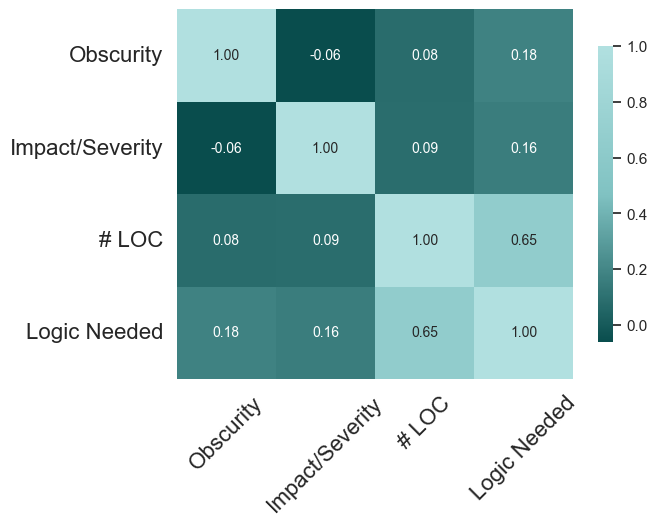

In [41]:
# Convert low, medium, high to 1, 2, 3 for 'Obscurity', 'Impact/Severity', '# LOC', and 'Logic Needed'
df_temp = df.copy()
df_temp['Impact/Severity'] = df['Impact/Severity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['Obscurity'] = df['Obscurity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['# LOC'] = df['# LOC'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
df_temp['Logic Needed'] = df['Logic Needed'].map({'Low': 1, 'Medium': 2, 'High': 3})

df_temp = df_temp[['Obscurity', 'Impact/Severity', '# LOC', 'Logic Needed']]
df_temp = df_temp.dropna()
print(df_temp)
print(df_temp.corr())

# colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])
# sns.heatmap(df_temp.corr(), annot=True, annot_kws={"size": 12}, cmap=custom_cmap, fmt=".2f")
# plt.savefig(SAVE_PATH+'correlation_plot.png', transparent=True)
# plt.show()

colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])

# Create the heatmap
heatmap = sns.heatmap(df_temp.corr(),
                       annot=True,
                       annot_kws={"size": 10},  # Set the font size for annotations
                       cmap=custom_cmap,
                       fmt=".2f",
                       cbar_kws={'shrink': .8})  # Optional: adjust color bar size

# Set the tick labels size and rotation
plt.xticks(fontsize=16, rotation=45)  # X-axis tick labels
plt.yticks(fontsize=16, rotation=0)   # Y-axis tick labels

# Save and show the plot
plt.savefig(SAVE_PATH+'correlation_plot.png', transparent=True)
plt.show()